In [19]:
# -*- coding: utf-8 -*-
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from configparser import ConfigParser
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# 為cartpy0.17bug暫時添加
import six
from PIL import Image


In [2]:
cfg = ConfigParser()
cfg.read('config.ini')
ftype = cfg['file']['filetype'].lower()
fname = cfg['file']['filename']
df = gp.read_file("./input/{}.{}".format(fname, ftype), encoding='utf-8')
df.head()

,TOWNID,TOWNCODE,COUNTYNAME,TOWNNAME,TOWNENG,COUNTYID,COUNTYCODE,geometry
0,V02,10014020,臺東縣,成功鎮,Chenggong Township,V,10014,"POLYGON ((121.40982 23.21369, 121.40984 23.213..."
1,T21,10013210,屏東縣,佳冬鄉,Jiadong Township,T,10013,"POLYGON ((120.54846 22.46067, 120.54853 22.460..."
2,P13,10009130,雲林縣,麥寮鄉,Mailiao Township,P,10009,"POLYGON ((120.30198 23.81625, 120.30197 23.815..."
3,V11,10014110,臺東縣,綠島鄉,Ludao Township,V,10014,"MULTIPOLYGON (((121.49155 22.67746, 121.49185 ..."
4,V16,10014160,臺東縣,蘭嶼鄉,Lanyu Township,V,10014,"MULTIPOLYGON (((121.61180 21.94290, 121.61133 ..."


In [3]:
print("檔案原座標系統： {}".format(df.crs))
# 座標轉換
df = df.to_crs(epsg=4326)
print("轉換為： {}".format(df.crs))
# 只取geometry
label = u"臺北市"
df = df[df["COUNTYNAME"]==label]
df = df[['COUNTYNAME','geometry']]
df.reset_index(drop=True)
#ax = df.plot(color="blue")
#df.to_file("./output/result.shp")

檔案原座標系統： epsg:3824
轉換為： epsg:4326


,COUNTYNAME,geometry
0,臺北市,"POLYGON ((121.54384 25.04491, 121.54407 25.044..."
1,臺北市,"POLYGON ((121.59725 25.01439, 121.59724 25.014..."
2,臺北市,"POLYGON ((121.57995 25.04950, 121.57996 25.049..."
3,臺北市,"POLYGON ((121.50521 25.04949, 121.50554 25.049..."
4,臺北市,"POLYGON ((121.51341 25.04940, 121.51375 25.049..."
5,臺北市,"POLYGON ((121.61425 25.06451, 121.61425 25.064..."
6,臺北市,"POLYGON ((121.56971 25.07629, 121.56981 25.076..."
7,臺北市,"POLYGON ((121.51410 25.07942, 121.51488 25.079..."
8,臺北市,"POLYGON ((121.54147 25.09287, 121.54155 25.092..."
9,臺北市,"POLYGON ((121.59359 25.11515, 121.59368 25.115..."


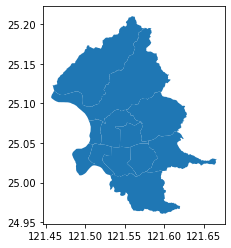

In [4]:
df.plot()

In [5]:
# shapely物件 bounds 回傳經緯度min/max (minx/miny/maxx/maxy)
bounds = df.geometry.bounds
margin = 0.03
bound = [min(bounds.minx)-margin, max(bounds.maxx)+margin,
         min(bounds.miny)-margin, max(bounds.maxy)+margin]
bound

[121.42714093900005,
 121.69593430800003,
 24.930502697000037,
 25.240175205000043]

In [6]:
def new_get_image(self, tile):
    if six.PY3:
        from urllib.request import urlopen, Request
    else:
        from urllib2 import urlopen
    url = self._image_url(tile)  # added by H.C. Winsemius
    req = Request(url) # added by H.C. Winsemius
    req.add_header('User-agent', 'your bot 0.1')
    # fh = urlopen(url)  # removed by H.C. Winsemius
    fh = urlopen(req)
    im_data = six.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)

    img = img.convert(self.desired_tile_form)

    return img, self.tileextent(tile), 'lower'

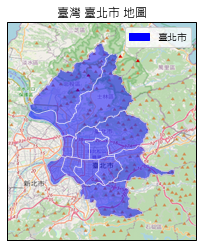

In [22]:
# 解決matplotlib本身不支援中文字體 會顯示成方塊的問題
# 參見： https://stackoverflow.com/questions/10960463/non-ascii-characters-in-matplotlib
plt.rcParams['axes.unicode_minus'] = False # 解決負號 '-' 顯示為方塊的問題
plt.rc('font', **{'sans-serif' : 'Microsoft JhengHei', # 指定中文字體 (微軟正黑體)
                  'family' : 'sans-serif'}) # 指定默認字型

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_title("臺灣 {} 地圖".format(label))
ax.set_extent(bound, ccrs.PlateCarree())
OSM.get_image = new_get_image
imagery = OSM()
# interpolation: matplotlib抗鋸齒
# 待0.18.1發佈更新 可修正下述bug
# cartopy0.18版interpolation有bug
# 參見: https://github.com/SciTools/cartopy/issues/1563
# cartopy0.17版add_image有bug
# 參見: https://github.com/SciTools/cartopy/issues/1341
zoom = 11
inter = 'spline36'
# regrid_shape: basemap長寬之短邊尺寸
regrid = 2500
dpi = 3000
ax.add_image(imagery, zoom, interpolation=inter, regrid_shape=regrid)
geom_facecolor = 'blue'
ax.add_geometries(df.geometry, ccrs.PlateCarree(),
                  edgecolor='white', facecolor=geom_facecolor, alpha=0.5)

# plt.plot的圖例可指定實例讓handles自動生成
# add_geometries的圖例需透過mpatches.Patch
patch = mpatches.Patch(color=geom_facecolor, label=label)
plt.legend(handles=[patch], loc='best')
plt.savefig('./output/{}_{}_regrid{}_dpi{}_{}.jpg'.format(zoom, inter, regrid, dpi, fname),
            dpi=dpi)
plt.show()